In [2]:
from datetime import datetime,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.model_selection import GridSearchCV
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
#read the data with some preprocessing already done
data = pd.read_csv("data_new.csv")
data.head()

,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceYearMonth,Revenue,MinPurchaseDate,MinPurchaseYearMonth
0,6,2010-12-01 08:26:00,2.55,17850.0,201012,15.30,2010-12-01 08:26:00,201012
1,6,2010-12-01 08:26:00,3.39,17850.0,201012,20.34,2010-12-01 08:26:00,201012
2,8,2010-12-01 08:26:00,2.75,17850.0,201012,22.00,2010-12-01 08:26:00,201012
3,6,2010-12-01 08:26:00,3.39,17850.0,201012,20.34,2010-12-01 08:26:00,201012
4,6,2010-12-01 08:26:00,3.39,17850.0,201012,20.34,2010-12-01 08:26:00,201012


In [4]:
#convert the column into date time object
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])


In [5]:
#data is divided into two parts, 6 months for building features and 3 months for calculating labels
data_6m = data[(data["InvoiceDate"] > pd.Timestamp(date(2011,1,1))) & (data["InvoiceDate"] < pd.Timestamp(date(2011,6,30)))]
data_3m = data[(data["InvoiceDate"] > pd.Timestamp(date(2011,7,1))) & (data["InvoiceDate"] < pd.Timestamp(date(2011,9,30)))]

In [6]:
data_6m=data_6m.drop(["MinPurchaseDate","MinPurchaseYearMonth"],axis=1)
data_6m.head()

,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceYearMonth,Revenue
297,1,2011-02-10 14:38:00,4.95,17850.0,201102,4.95
298,6,2011-02-10 14:38:00,1.85,17850.0,201102,11.10
299,1,2011-02-10 14:38:00,4.95,17850.0,201102,4.95
300,1,2011-02-10 14:38:00,1.06,17850.0,201102,1.06
301,2,2011-02-10 14:38:00,2.55,17850.0,201102,5.10


## RFM for 6 Months Data to be used as Features

In [7]:
#get the max purchase date(last recorded date of each customer) for each customer and create a dataframe with it
max_purchase = data_6m.groupby('CustomerID')["InvoiceDate"].max().reset_index()
max_purchase.columns = ['CustomerID','MaxPurchaseDate']

max_purchase['Recency'] = (max_purchase['MaxPurchaseDate'].max() - max_purchase['MaxPurchaseDate']).dt.days
max_purchase.head()

,CustomerID,MaxPurchaseDate,Recency
0,12346.0,2011-01-18 10:17:00,162
1,12747.0,2011-06-28 10:06:00,1
2,12748.0,2011-06-28 12:16:00,1
3,12749.0,2011-05-23 17:08:00,36
4,12820.0,2011-01-17 12:34:00,163


In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(max_purchase[['Recency']])
max_purchase['RecencyCluster'] = kmeans.predict(max_purchase[['Recency']])
max_purchase.head()

,CustomerID,MaxPurchaseDate,Recency,RecencyCluster
0,12346.0,2011-01-18 10:17:00,162,1
1,12747.0,2011-06-28 10:06:00,1,2
2,12748.0,2011-06-28 12:16:00,1,2
3,12749.0,2011-05-23 17:08:00,36,0
4,12820.0,2011-01-17 12:34:00,163,1


In [9]:
max_purchase.groupby("RecencyCluster")['Recency'].mean().reset_index()

,RecencyCluster,Recency
0,0,44.822684
1,1,143.018135
2,2,13.131952
3,3,89.650362


In [10]:
max_purchase["RecencyCluster"] = max_purchase["RecencyCluster"].map({1:0,3:1,0:2,2:3})
max_purchase

,CustomerID,MaxPurchaseDate,Recency,RecencyCluster
0,12346.0,2011-01-18 10:17:00,162,0
1,12747.0,2011-06-28 10:06:00,1,3
2,12748.0,2011-06-28 12:16:00,1,3
3,12749.0,2011-05-23 17:08:00,36,2
4,12820.0,2011-01-17 12:34:00,163,0
...,...,...,...,...
2476,18277.0,2011-01-25 12:34:00,155,0
2477,18280.0,2011-03-07 09:52:00,114,1
2478,18281.0,2011-06-12 10:53:00,17,3
2479,18283.0,2011-06-23 19:20:00,5,3


In [11]:
recency_df = max_purchase[["CustomerID","Recency","RecencyCluster"]]
recency_df.head()

,CustomerID,Recency,RecencyCluster
0,12346.0,162,0
1,12747.0,1,3
2,12748.0,1,3
3,12749.0,36,2
4,12820.0,163,0


In [12]:
frequency = data_6m.groupby('CustomerID').InvoiceDate.count().reset_index()
frequency.columns = ['CustomerID','Frequency']

kmeans = KMeans(n_clusters=4)
kmeans.fit(frequency[['Frequency']])
frequency['FrequencyCluster'] = kmeans.predict(frequency[['Frequency']])
frequency.head()

,CustomerID,Frequency,FrequencyCluster
0,12346.0,2,0
1,12747.0,48,0
2,12748.0,969,1
3,12749.0,54,0
4,12820.0,11,0


In [13]:
frequency.groupby("FrequencyCluster")["Frequency"].mean().reset_index()

,FrequencyCluster,Frequency
0,0,30.995872
1,1,771.600000
2,2,176.119298
3,3,2419.000000


In [14]:
frequency["FrequencyCluster"] = frequency["FrequencyCluster"].map({0:0,2:1,1:2,3:3})
frequency_df = frequency.copy()
frequency_df.head()

,CustomerID,Frequency,FrequencyCluster
0,12346.0,2,0
1,12747.0,48,0
2,12748.0,969,2
3,12749.0,54,0
4,12820.0,11,0


In [15]:
revenue = data_6m.groupby('CustomerID').Revenue.sum().reset_index()
kmeans = KMeans(n_clusters=4)
kmeans.fit(revenue[['Revenue']])
revenue['RevenueCluster'] = kmeans.predict(revenue[['Revenue']])
revenue.head()

,CustomerID,Revenue,RevenueCluster
0,12346.0,154367.20,3
1,12747.0,1761.43,0
2,12748.0,7504.77,0
3,12749.0,936.10,0
4,12820.0,170.46,0


In [16]:
revenue.groupby("RevenueCluster")["Revenue"].mean().reset_index()

,RevenueCluster,Revenue
0,0,851.565436
1,1,71620.412500
2,2,22044.638889
3,3,154367.200000


In [17]:
revenue["RevenueCluster"] = revenue["RevenueCluster"].map({0:0,2:1,1:2,3:3})
revenue_df = revenue.copy()
revenue_df.head()

,CustomerID,Revenue,RevenueCluster
0,12346.0,154367.20,3
1,12747.0,1761.43,0
2,12748.0,7504.77,0
3,12749.0,936.10,0
4,12820.0,170.46,0


In [18]:
#merging all three dataset to give final features dataframe
features_df = pd.merge(recency_df,frequency_df,on = "CustomerID")
features_df = pd.merge(features_df,revenue_df,on = "CustomerID")
features_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,12346.0,162,0,2,0,154367.20,3
1,12747.0,1,3,48,0,1761.43,0
2,12748.0,1,3,969,2,7504.77,0
3,12749.0,36,2,54,0,936.10,0
4,12820.0,163,0,11,0,170.46,0


In [19]:
features_df["Overall Score"] = features_df["RecencyCluster"] + features_df["FrequencyCluster"] + features_df["RevenueCluster"]
features_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,Overall Score
0,12346.0,162,0,2,0,154367.20,3,3
1,12747.0,1,3,48,0,1761.43,0,3
2,12748.0,1,3,969,2,7504.77,0,5
3,12749.0,36,2,54,0,936.10,0,2
4,12820.0,163,0,11,0,170.46,0,0


## Lifetime Value Prediction (LTV)

LTV = Revenue - Total cost of acquisition

Since no acquisition cost is provided , LTV is Revenue only

In [178]:
#three months data for building LTV that is revenue
revenue_3m = data_3m.groupby('CustomerID')['Revenue'].sum().reset_index()
revenue_3m.columns = ['CustomerID','m3_Revenue']
revenue_3m.head()

,CustomerID,m3_Revenue
0,12747.0,301.70
1,12748.0,8814.94
2,12749.0,2041.81
3,12820.0,217.77
4,12822.0,720.80


In [21]:
Final_df = pd.merge(features_df,revenue_3m,on = "CustomerID")
Final_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,Overall Score,m3_Revenue
0,12747.0,1,3,48,0,1761.43,0,3,301.70
1,12748.0,1,3,969,2,7504.77,0,5,8814.94
2,12749.0,36,2,54,0,936.10,0,2,2041.81
3,12820.0,163,0,11,0,170.46,0,0,217.77
4,12823.0,91,1,3,0,994.50,0,1,765.00


In [22]:
#using a copy of main data frame so that it can be used many times
Final_df1 = Final_df.copy()

In [23]:
#.quantile(0.99) return values below which 99 % data exists
Final_df1 = Final_df1[Final_df1["m3_Revenue"]<Final_df1["m3_Revenue"].quantile(0.99)]
Final_df1.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,Overall Score,m3_Revenue
0,12747.0,1,3,48,0,1761.43,0,3,301.70
1,12748.0,1,3,969,2,7504.77,0,5,8814.94
2,12749.0,36,2,54,0,936.10,0,2,2041.81
3,12820.0,163,0,11,0,170.46,0,0,217.77
4,12823.0,91,1,3,0,994.50,0,1,765.00


<Axes: xlabel='Overall Score', ylabel='m3_Revenue'>

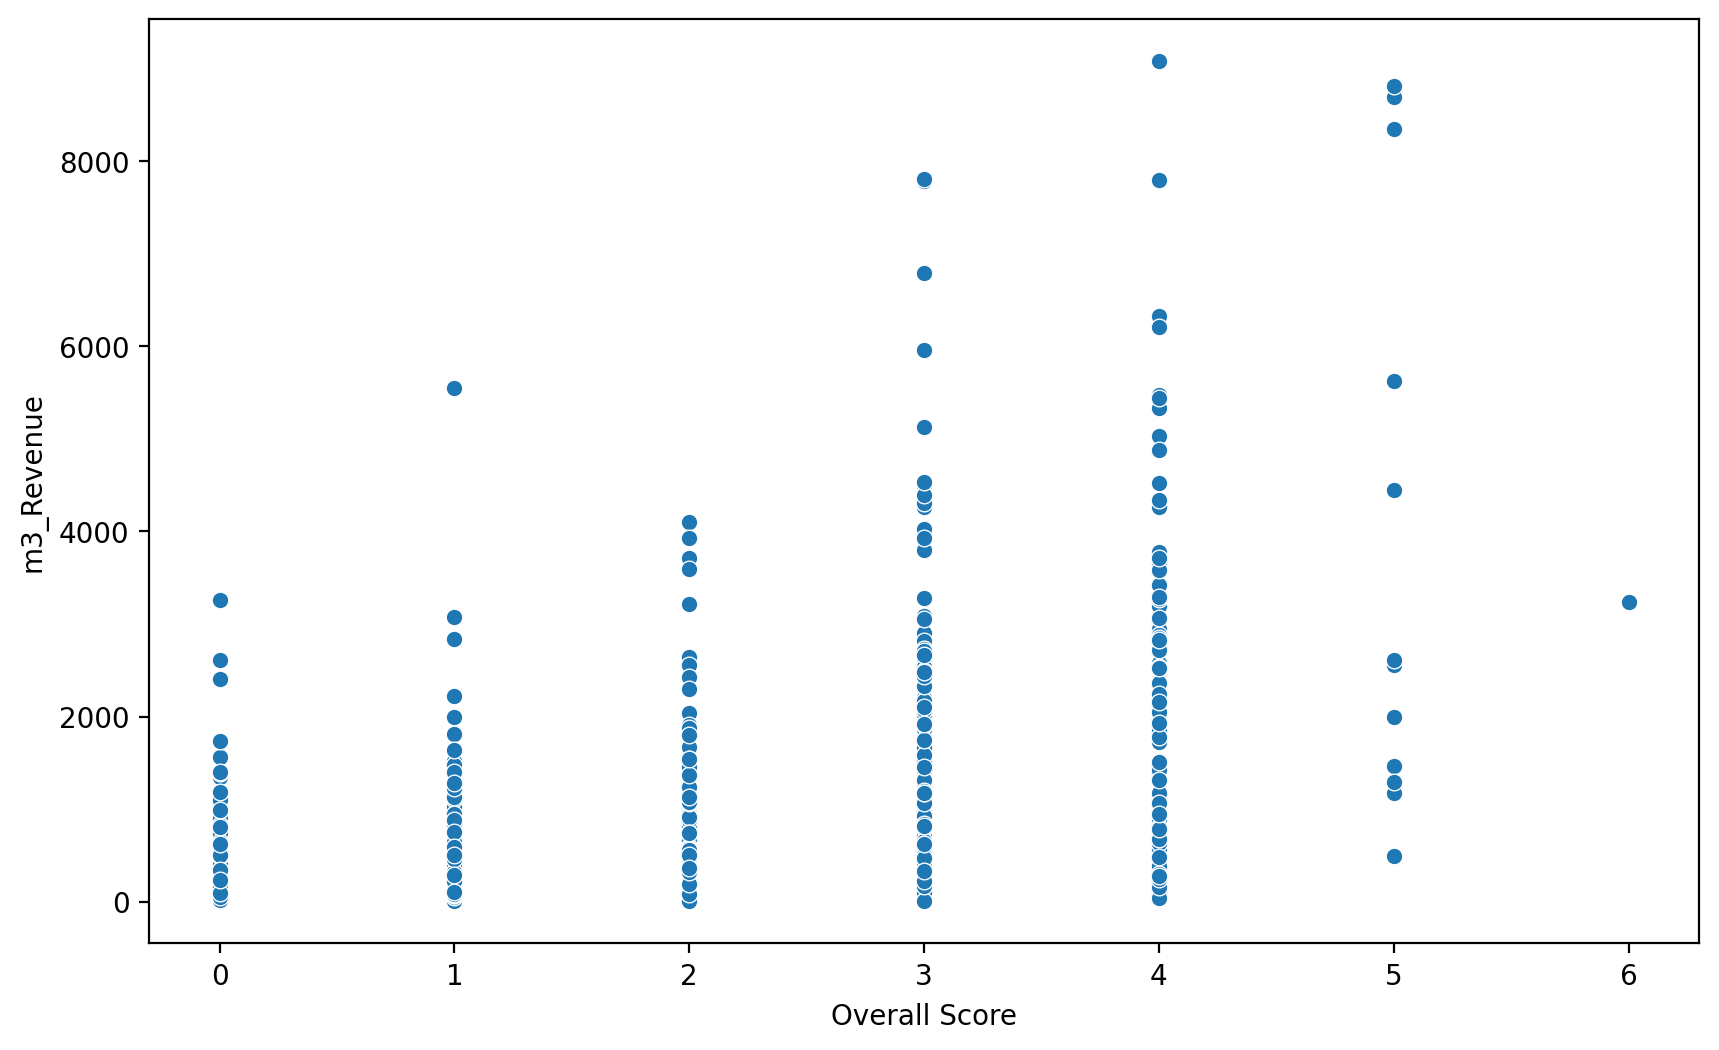

In [24]:
#high overall RFM score high 6 month revenue
plt.figure(figsize=(10,6),dpi = 200)
sns.scatterplot(data=Final_df1,x="Overall Score",y="m3_Revenue")

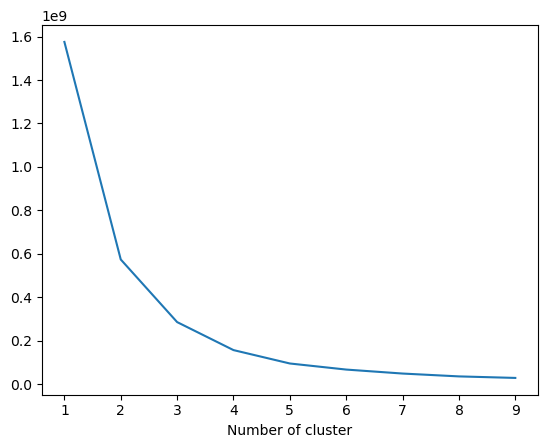

In [25]:
#Elbow method to select number of clusters


sse={}
m3_revenue_copy = Final_df1[['m3_Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(m3_revenue_copy)
    m3_revenue_copy['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [26]:
#4 cluster is very hard target of classifiers with very few data rows in both training and test samples
kmeans = KMeans(n_clusters=3)
kmeans.fit(Final_df1[['m3_Revenue']])
Final_df1['LTVCluster'] = kmeans.predict(Final_df1[['m3_Revenue']])
Final_df1.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,Overall Score,m3_Revenue,LTVCluster
0,12747.0,1,3,48,0,1761.43,0,3,301.70,0
1,12748.0,1,3,969,2,7504.77,0,5,8814.94,1
2,12749.0,36,2,54,0,936.10,0,2,2041.81,2
3,12820.0,163,0,11,0,170.46,0,0,217.77,0
4,12823.0,91,1,3,0,994.50,0,1,765.00,0


In [27]:
#cluster with their mean revenue value
Final_df1.groupby('LTVCluster')['m3_Revenue'].mean()

LTVCluster
0     463.459691
1    5773.220000
2    1993.886650
Name: m3_Revenue, dtype: float64

In [28]:
Final_df1["LTVCluster"] = Final_df1["LTVCluster"].map({0:0,2:1,1:2})

In [29]:
Final_df1.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,Overall Score,m3_Revenue,LTVCluster
0,12747.0,1,3,48,0,1761.43,0,3,301.70,0
1,12748.0,1,3,969,2,7504.77,0,5,8814.94,2
2,12749.0,36,2,54,0,936.10,0,2,2041.81,1
3,12820.0,163,0,11,0,170.46,0,0,217.77,0
4,12823.0,91,1,3,0,994.50,0,1,765.00,0


In [30]:
#2nd cluster have only 36 data rows 
Final_df1.groupby("LTVCluster")["m3_Revenue"].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,1065.0,463.459691,308.990519,1.65,224.94,375.93,659.850,1225.03
1,197.0,1993.886650,666.805243,1230.69,1435.06,1807.80,2427.300,3795.11
2,36.0,5773.220000,1664.175287,3923.44,4382.05,5339.34,7039.785,9078.02


In [31]:
Final_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1298 entries, 0 to 1311
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        1298 non-null   float64
 1   Recency           1298 non-null   int64  
 2   RecencyCluster    1298 non-null   int64  
 3   Frequency         1298 non-null   int64  
 4   FrequencyCluster  1298 non-null   int64  
 5   Revenue           1298 non-null   float64
 6   RevenueCluster    1298 non-null   int64  
 7   Overall Score     1298 non-null   int64  
 8   m3_Revenue        1298 non-null   float64
 9   LTVCluster        1298 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 111.5 KB


In [32]:
#m3 revenue is direclty correlated with clusters
X = Final_df1.drop(['LTVCluster','m3_Revenue'],axis=1)
y = Final_df1['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [33]:
X_train.shape 

(1038, 8)

In [34]:
y_train.shape

(1038,)

In [35]:
#xgboost under default setting , mlogloss is multiclass logarithmic loss (essentially cross entropy loss)
xgb_clf = xgb.XGBClassifier(eval_metric='mlogloss')

# Fit the classifier to the training data
xgb_clf.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [36]:
#Accuracy on Training data
y_pred_train_data = xgb_clf.predict(X_train)
accuracy_train_data = accuracy_score(y_train, y_pred_train_data)

#Accuracy over test (unseen) data
y_pred_test_data = xgb_clf.predict(X_test)
accuracy_test_data = accuracy_score(y_test, y_pred_test_data)


print(f"Accuracy on train dataset:{accuracy_train_data}")
print(f"Accuracy on test dataset:{accuracy_test_data}")

Accuracy on train dataset:1.0
Accuracy on test dataset:0.8576923076923076


In [37]:
#Grid Search for better hyperparameter tuning

#subsample is taking a bootstrapped dataset for training 
param_grid = {
    'n_estimators': [10,20,30,50],
    'max_depth': [2,3,4,5,6,8],
    'learning_rate': [0.05,0.06,0.07,0.08,0.09,0.1,0.2],
    'subsample': [0.6,0.7,0.8,0.9,1.0]
}
# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(eval_metric='mlogloss')

# Initialize the GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=3,verbose = 2, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_


y_pred = grid_search.predict(X_test)
accuracy_test_data = accuracy_score(y_test, y_pred)



print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")
print(f"Accuracy on test data:{accuracy_test_data}")

Fitting 3 folds for each of 840 candidates, totalling 2520 fits
Best parameters found: {'learning_rate': 0.07, 'max_depth': 2, 'n_estimators': 20, 'subsample': 0.8}
Best cross-validation accuracy: 0.8497109826589595
Accuracy on test data:0.8692307692307693


              precision    recall  f1-score   support

           0       0.92      0.94      0.93       214
           1       0.61      0.47      0.54        40
           2       0.56      0.83      0.67         6

    accuracy                           0.87       260
   macro avg       0.70      0.75      0.71       260
weighted avg       0.86      0.87      0.86       260



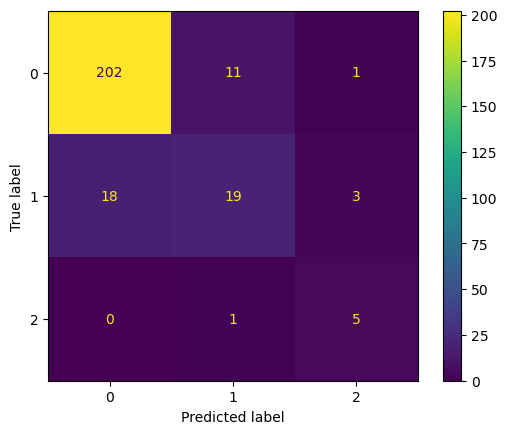

In [38]:
#prediction from best model given by grid search

best_xgb_clf = grid_search.best_estimator_
y_pred = best_xgb_clf.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

cmp = ConfusionMatrixDisplay(confusion_matrix=cm)
cmp.plot()


## Predicting Next Purchase Day

In [129]:
#dataframe for first purchase in coming 3 months
next_first_purchase = data_3m.groupby('CustomerID').InvoiceDate.min().reset_index()
next_first_purchase.columns = ['CustomerID','MinPurchaseDate']
next_first_purchase.head()

,CustomerID,MinPurchaseDate
0,12747.0,2011-08-22 10:38:00
1,12748.0,2011-07-01 12:45:00
2,12749.0,2011-08-01 12:48:00
3,12820.0,2011-09-26 11:49:00
4,12822.0,2011-09-13 13:46:00


In [130]:
#dataframe for last purchase in 6 months
last_purchase = data_6m.groupby('CustomerID').InvoiceDate.max().reset_index()
last_purchase.columns = ['CustomerID','MaxPurchaseDate']
last_purchase.head()

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-06-28 10:06:00
2,12748.0,2011-06-28 12:16:00
3,12749.0,2011-05-23 17:08:00
4,12820.0,2011-01-17 12:34:00


In [131]:
#combining both above dataframe
purchase_dates = pd.merge(last_purchase,next_first_purchase,on='CustomerID',how='left')
#calculating gaps in day between last purchase(6m data) and first purchase(3m data)
purchase_dates['NextPurchaseDay'] = (purchase_dates['MinPurchaseDate'] - purchase_dates['MaxPurchaseDate']).dt.days
purchase_dates.head()


,CustomerID,MaxPurchaseDate,MinPurchaseDate,NextPurchaseDay
0,12346.0,2011-01-18 10:17:00,NaT,NaN
1,12747.0,2011-06-28 10:06:00,2011-08-22 10:38:00,55.0
2,12748.0,2011-06-28 12:16:00,2011-07-01 12:45:00,3.0
3,12749.0,2011-05-23 17:08:00,2011-08-01 12:48:00,69.0
4,12820.0,2011-01-17 12:34:00,2011-09-26 11:49:00,251.0


In [132]:
purchase_dates = purchase_dates.drop(["MaxPurchaseDate","MinPurchaseDate"],axis=1)
purchase_dates.head()

,CustomerID,NextPurchaseDay
0,12346.0,NaN
1,12747.0,55.0
2,12748.0,3.0
3,12749.0,69.0
4,12820.0,251.0


In [133]:
#final dataframe along with nan values replaced by 999 so that we can identify them later
Final_df2 = purchase_dates.fillna(999)
Final_df2.head()

,CustomerID,NextPurchaseDay
0,12346.0,999.0
1,12747.0,55.0
2,12748.0,3.0
3,12749.0,69.0
4,12820.0,251.0


In [134]:
#adding RFM to the data
Final_df2 = pd.merge(Final_df,Final_df2,on="CustomerID",how = "left")

In [135]:
#only purchase is used for three month
Final_df2 = Final_df2.drop(["m3_Revenue"],axis=1)
Final_df2

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,Overall Score,NextPurchaseDay
0,12747.0,1,3,48,0,1761.43,0,3,55.0
1,12748.0,1,3,969,2,7504.77,0,5,3.0
2,12749.0,36,2,54,0,936.10,0,2,69.0
3,12820.0,163,0,11,0,170.46,0,0,251.0
4,12823.0,91,1,3,0,994.50,0,1,127.0
...,...,...,...,...,...,...,...,...,...
1307,18257.0,5,3,48,0,1007.85,0,3,54.0
1308,18263.0,89,1,15,0,307.60,0,1,96.0
1309,18272.0,49,2,59,0,994.34,0,2,62.0
1310,18273.0,94,1,1,0,51.00,0,1,162.0


In [136]:
Final_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1312 entries, 0 to 1311
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        1312 non-null   float64
 1   Recency           1312 non-null   int64  
 2   RecencyCluster    1312 non-null   int64  
 3   Frequency         1312 non-null   int64  
 4   FrequencyCluster  1312 non-null   int64  
 5   Revenue           1312 non-null   float64
 6   RevenueCluster    1312 non-null   int64  
 7   Overall Score     1312 non-null   int64  
 8   NextPurchaseDay   1312 non-null   float64
dtypes: float64(3), int64(6)
memory usage: 102.5 KB


In [137]:
#getting only date on which customer purchased something
day_order = data_6m[['CustomerID','InvoiceDate']]
day_order['InvoiceDay'] = data_6m['InvoiceDate'].dt.date
day_order = day_order.sort_values(['CustomerID','InvoiceDate'])
day_order.head()

,CustomerID,InvoiceDate,InvoiceDay
179233,12346.0,2011-01-18 10:01:00,2011-01-18
179234,12346.0,2011-01-18 10:17:00,2011-01-18
67846,12747.0,2011-01-20 14:01:00,2011-01-20
67847,12747.0,2011-01-20 14:01:00,2011-01-20
67848,12747.0,2011-01-20 14:01:00,2011-01-20


In [138]:
#we need to drop duplicates as a customer can make multiple purchase in a single day
#subset means to consider these columns only
day_order = day_order.drop_duplicates(subset=['CustomerID','InvoiceDay'],keep='first')

In [139]:
day_order.head()

,CustomerID,InvoiceDate,InvoiceDay
179233,12346.0,2011-01-18 10:01:00,2011-01-18
67846,12747.0,2011-01-20 14:01:00,2011-01-20
67851,12747.0,2011-03-01 14:53:00,2011-03-01
67863,12747.0,2011-05-05 15:31:00,2011-05-05
67872,12747.0,2011-05-25 09:57:00,2011-05-25


In [140]:
#finding three dates of previous purchases

#previous date of purchase from current one
day_order['PrevInvoiceDate'] = day_order.groupby('CustomerID')['InvoiceDay'].shift(1)
#previous purchase date from previous one above
day_order['T2InvoiceDate'] = day_order.groupby('CustomerID')['InvoiceDay'].shift(2)
#previous purchase date from previous one above
day_order['T3InvoiceDate'] = day_order.groupby('CustomerID')['InvoiceDay'].shift(3)

In [141]:
day_order

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate
179233,12346.0,2011-01-18 10:01:00,2011-01-18,NaN,NaN,NaN
67846,12747.0,2011-01-20 14:01:00,2011-01-20,NaN,NaN,NaN
67851,12747.0,2011-03-01 14:53:00,2011-03-01,2011-01-20,NaN,NaN
67863,12747.0,2011-05-05 15:31:00,2011-05-05,2011-03-01,2011-01-20,NaN
67872,12747.0,2011-05-25 09:57:00,2011-05-25,2011-05-05,2011-03-01,2011-01-20
...,...,...,...,...,...,...
161162,18283.0,2011-04-21 16:37:00,2011-04-21,2011-02-28,2011-01-23,2011-01-06
161218,18283.0,2011-05-23 11:33:00,2011-05-23,2011-04-21,2011-02-28,2011-01-23
161262,18283.0,2011-06-14 11:41:00,2011-06-14,2011-05-23,2011-04-21,2011-02-28
161286,18283.0,2011-06-23 19:20:00,2011-06-23,2011-06-14,2011-05-23,2011-04-21


In [142]:
#converting dates into gaps in number of days

#gap of days between current and previous purchase
day_order['DayDiff'] = (day_order['InvoiceDay'] - day_order['PrevInvoiceDate']).dt.days
#gap of days between previous and previous to previous purchase
day_order['DayDiff2'] = (day_order['InvoiceDay'] - day_order['T2InvoiceDate']).dt.days
day_order['DayDiff3'] = (day_order['InvoiceDay'] - day_order['T3InvoiceDate']).dt.days

In [143]:
day_order.head()

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
179233,12346.0,2011-01-18 10:01:00,2011-01-18,NaN,NaN,NaN,NaN,NaN,NaN
67846,12747.0,2011-01-20 14:01:00,2011-01-20,NaN,NaN,NaN,NaN,NaN,NaN
67851,12747.0,2011-03-01 14:53:00,2011-03-01,2011-01-20,NaN,NaN,40.0,NaN,NaN
67863,12747.0,2011-05-05 15:31:00,2011-05-05,2011-03-01,2011-01-20,NaN,65.0,105.0,NaN
67872,12747.0,2011-05-25 09:57:00,2011-05-25,2011-05-05,2011-03-01,2011-01-20,20.0,85.0,125.0


In [144]:
#all customer id is added with mean and S.D. of their purchases with previous purchase date
day_diff = day_order.groupby('CustomerID').agg({'DayDiff': ['mean','std']}).reset_index()
day_diff.columns = ['CustomerID', 'DayDiffMean','DayDiffStd']
day_diff.head()

,CustomerID,DayDiffMean,DayDiffStd
0,12346.0,NaN,NaN
1,12747.0,39.750000,18.803812
2,12748.0,4.833333,5.500649
3,12749.0,13.000000,NaN
4,12820.0,NaN,NaN


In [145]:
#some S.D. only having one values should have value zero but here its filled with NaN
#we will fill it with 0 value
day_diff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2481 entries, 0 to 2480
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CustomerID   2481 non-null   float64
 1   DayDiffMean  1417 non-null   float64
 2   DayDiffStd   839 non-null    float64
dtypes: float64(3)
memory usage: 58.3 KB


In [146]:
day_diff["DayDiffStd"] = day_diff["DayDiffStd"].fillna(0)
day_diff = day_diff.dropna()
day_diff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1417 entries, 1 to 2479
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CustomerID   1417 non-null   float64
 1   DayDiffMean  1417 non-null   float64
 2   DayDiffStd   1417 non-null   float64
dtypes: float64(3)
memory usage: 44.3 KB


In [147]:
#say a customer made 6 purchases on diffrent dates
#last occurance of its customer id in data will have all Daydiff,Daydiff2,Daydiff3
#while its third occurance will not have Daydiff3 and second occurance will not have both Daydiff2,Daydiff3.
#so by keeping last occurance and using dropna , only customer id with minimum 4 previous purchases will considered

day_order_last = day_order.drop_duplicates(subset=['CustomerID'],keep='last')

day_order_last = day_order_last.dropna()
day_order_last.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 554 entries, 67886 to 161286
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   CustomerID       554 non-null    float64       
 1   InvoiceDate      554 non-null    datetime64[ns]
 2   InvoiceDay       554 non-null    object        
 3   PrevInvoiceDate  554 non-null    object        
 4   T2InvoiceDate    554 non-null    object        
 5   T3InvoiceDate    554 non-null    object        
 6   DayDiff          554 non-null    float64       
 7   DayDiff2         554 non-null    float64       
 8   DayDiff3         554 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 43.3+ KB


In [148]:
#however the daydiff data is for all customers (no limit of more than 3 purchases)

Final_df3 = pd.merge(day_order_last,day_diff, on='CustomerID',how = "left")
Final_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 554 entries, 0 to 553
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   CustomerID       554 non-null    float64       
 1   InvoiceDate      554 non-null    datetime64[ns]
 2   InvoiceDay       554 non-null    object        
 3   PrevInvoiceDate  554 non-null    object        
 4   T2InvoiceDate    554 non-null    object        
 5   T3InvoiceDate    554 non-null    object        
 6   DayDiff          554 non-null    float64       
 7   DayDiff2         554 non-null    float64       
 8   DayDiff3         554 non-null    float64       
 9   DayDiffMean      554 non-null    float64       
 10  DayDiffStd       554 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 51.9+ KB


In [149]:
#merging all the data into one Final_df4
Final_df4 = pd.merge(Final_df3,Final_df2,on='CustomerID',)
Final_df4.head()

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,Overall Score,NextPurchaseDay
0,12747.0,2011-06-28 10:06:00,2011-06-28,2011-05-25,2011-05-05,2011-03-01,34.0,54.0,119.0,39.750000,18.803812,1,3,48,0,1761.43,0,3,55.0
1,12748.0,2011-06-28 12:16:00,2011-06-28,2011-06-23,2011-06-22,2011-06-21,5.0,6.0,7.0,4.833333,5.500649,1,3,969,2,7504.77,0,5,3.0
2,12826.0,2011-06-24 11:47:00,2011-06-24,2011-06-14,2011-01-27,2011-01-19,10.0,148.0,156.0,52.000000,74.484898,5,3,50,0,670.22,0,3,96.0
3,12839.0,2011-06-09 14:43:00,2011-06-09,2011-05-25,2011-03-07,2011-02-25,15.0,94.0,104.0,34.666667,38.475100,20,3,64,0,966.22,0,3,25.0
4,12840.0,2011-06-10 10:29:00,2011-06-10,2011-05-09,2011-05-05,2011-05-04,32.0,36.0,37.0,11.000000,14.212670,19,3,93,0,2163.27,0,3,38.0


In [150]:
#these columns are not required
Final_df4 = Final_df4.drop(["InvoiceDate","InvoiceDay","PrevInvoiceDate","T2InvoiceDate","T3InvoiceDate"],axis = 1)

In [151]:
Final_df4.head()

,CustomerID,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,Overall Score,NextPurchaseDay
0,12747.0,34.0,54.0,119.0,39.750000,18.803812,1,3,48,0,1761.43,0,3,55.0
1,12748.0,5.0,6.0,7.0,4.833333,5.500649,1,3,969,2,7504.77,0,5,3.0
2,12826.0,10.0,148.0,156.0,52.000000,74.484898,5,3,50,0,670.22,0,3,96.0
3,12839.0,15.0,94.0,104.0,34.666667,38.475100,20,3,64,0,966.22,0,3,25.0
4,12840.0,32.0,36.0,37.0,11.000000,14.212670,19,3,93,0,2163.27,0,3,38.0


In [152]:
Final_df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 477 entries, 0 to 476
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        477 non-null    float64
 1   DayDiff           477 non-null    float64
 2   DayDiff2          477 non-null    float64
 3   DayDiff3          477 non-null    float64
 4   DayDiffMean       477 non-null    float64
 5   DayDiffStd        477 non-null    float64
 6   Recency           477 non-null    int64  
 7   RecencyCluster    477 non-null    int64  
 8   Frequency         477 non-null    int64  
 9   FrequencyCluster  477 non-null    int64  
 10  Revenue           477 non-null    float64
 11  RevenueCluster    477 non-null    int64  
 12  Overall Score     477 non-null    int64  
 13  NextPurchaseDay   477 non-null    float64
dtypes: float64(8), int64(6)
memory usage: 55.9 KB


In [153]:
Final_df4["NextPurchaseDay"].describe()

count    477.000000
mean      48.425577
std       32.833506
min        1.000000
25%       25.000000
50%       40.000000
75%       65.000000
max      208.000000
Name: NextPurchaseDay, dtype: float64

In [154]:
#converting target label from continous to categorical
#within 20 days purchase is classified as 2
#between 20 to 50 days is classified as 1
#above 50 days is classified as 0
def convert(x):
    if x < 20:
        return 2
    elif (20 < x < 50) :
        return 1
    else:
        return 0
    
    
Final_df4["Target"] = Final_df4["NextPurchaseDay"].apply(convert)
Final_df4

,CustomerID,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,Overall Score,NextPurchaseDay,Target
0,12747.0,34.0,54.0,119.0,39.750000,18.803812,1,3,48,0,1761.43,0,3,55.0,0
1,12748.0,5.0,6.0,7.0,4.833333,5.500649,1,3,969,2,7504.77,0,5,3.0,2
2,12826.0,10.0,148.0,156.0,52.000000,74.484898,5,3,50,0,670.22,0,3,96.0,0
3,12839.0,15.0,94.0,104.0,34.666667,38.475100,20,3,64,0,966.22,0,3,25.0,1
4,12840.0,32.0,36.0,37.0,11.000000,14.212670,19,3,93,0,2163.27,0,3,38.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,18226.0,13.0,41.0,58.0,25.333333,25.874054,22,3,114,1,2604.59,0,4,26.0,1
473,18229.0,13.0,27.0,47.0,22.571429,8.059304,8,3,61,0,2967.04,0,3,23.0,1
474,18230.0,34.0,79.0,129.0,43.000000,8.185353,10,3,57,0,1643.28,0,3,79.0,0
475,18257.0,23.0,32.0,38.0,21.333333,25.144913,5,3,48,0,1007.85,0,3,54.0,0


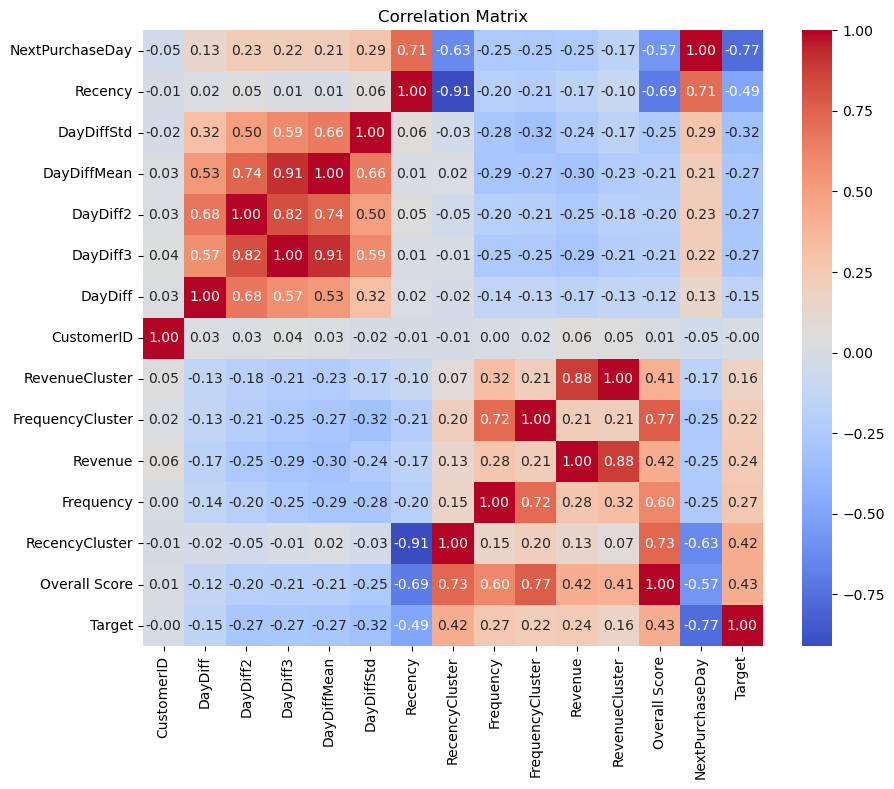

In [167]:
#.corr() returns a pandas dataframe of corr. coefficeint matrix

corr_matrix = Final_df4.corr()
corr_matrix = corr_matrix.sort_values(by = "Target" )
plt.figure(figsize=(10, 8))
#annot = True will also show numbers in the cell
#heatmap converts numbers into colours
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


#Recency,Daydiff is negatively correlated while revenue, frequency is positevely correlated
#as expected customer id is uncorrelated

In [168]:
#NextPurchaseday is direclty correlated with clusters
X = Final_df4.drop(["NextPurchaseDay","Target"],axis=1)
y = Final_df4['Target']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [169]:
X_train.shape

(381, 13)

In [173]:
y_test.shape

(96,)

In [171]:
#xgboost under default setting , mlogloss is multiclass logarithmic loss (essentially cross entropy loss)
xgb_clf = xgb.XGBClassifier(eval_metric='mlogloss')

# Fit the classifier to the training data
xgb_clf.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [172]:
#Accuracy on Training data
y_pred_train_data = xgb_clf.predict(X_train)
accuracy_train_data = accuracy_score(y_train, y_pred_train_data)

#Accuracy over test (unseen) data
y_pred_test_data = xgb_clf.predict(X_test)
accuracy_test_data = accuracy_score(y_test, y_pred_test_data)


print(f"Accuracy on train dataset:{accuracy_train_data}")
print(f"Accuracy on test dataset:{accuracy_test_data}")

Accuracy on train dataset:1.0
Accuracy on test dataset:0.5625


In [176]:
#Grid Search for better hyperparameter tuning

#subsample is taking a bootstrapped dataset for training 
param_grid = {
    'n_estimators': [10,20,30,50],
    'max_depth': [2,3,4,5,6,8],
    'learning_rate': [0.05,0.06,0.07,0.08,0.09,0.1,0.2],
    'subsample': [0.6,0.7,0.8,0.9,1.0]
}
# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(eval_metric='mlogloss')

# Initialize the GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=3,verbose = 2, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_


y_pred = grid_search.predict(X_test)
accuracy_test_data = accuracy_score(y_test, y_pred)



print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")
print(f"Accuracy on test data:{accuracy_test_data}")

Fitting 3 folds for each of 840 candidates, totalling 2520 fits
Best parameters found: {'learning_rate': 0.07, 'max_depth': 2, 'n_estimators': 20, 'subsample': 0.6}
Best cross-validation accuracy: 0.6614173228346457
Accuracy on test data:0.5729166666666666


              precision    recall  f1-score   support

           0       0.54      0.39      0.46        33
           1       0.52      0.74      0.62        43
           2       0.91      0.50      0.65        20

    accuracy                           0.57        96
   macro avg       0.66      0.55      0.57        96
weighted avg       0.61      0.57      0.57        96



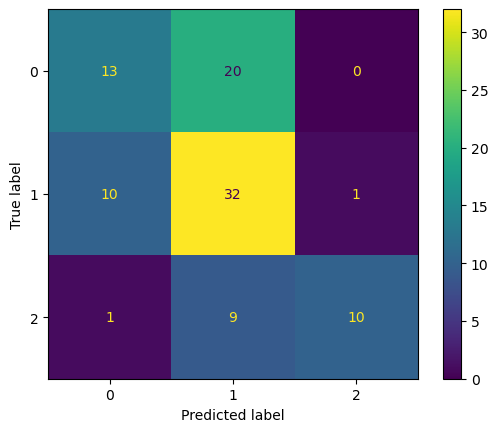

In [175]:
#very less data is the reason for poor accuracy
#prediction from best model given by grid search

best_xgb_clf = grid_search.best_estimator_
y_pred = best_xgb_clf.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

cmp = ConfusionMatrixDisplay(confusion_matrix=cm)
cmp.plot()
